In [1]:
import torch
from torch.utils.data import DataLoader
from pathlib import Path


from data_package.datasets import ImageSegmentationDataset
from data_package.transforms import (
    Compose, Resize, RandomHorizontalFlip, RandomVerticalFlip,RandomRotate90,ElasticDeformation,
    SelectGreenChannel, ApplyCLAHE,MultiBranchYCbCrPreprocess,
    ToTensor, Normalize,
)
from data_package.utils import train_val_test_split,compute_channel_mean_std,UNetWeightMapGenerator

In [2]:
img_dir = Path("./data/DRIVE/training/images")
mask_dir = Path("./data/DRIVE/training/1st_manual")

image_paths = sorted(str(p) for p in img_dir.glob("*.tif"))
mask_paths = sorted(str(p) for p in mask_dir.glob("*.gif"))

print("num images:", len(image_paths))
print("num masks :", len(mask_paths))
print("first image:", image_paths[0])
print("first mask :", mask_paths[0])

num images: 20
num masks : 20
first image: data/DRIVE/training/images/21_training.tif
first mask : data/DRIVE/training/1st_manual/21_manual1.gif


In [3]:
(
    train_imgs, val_imgs, test_imgs,
    train_masks, val_masks, test_masks
) = train_val_test_split(
    image_paths, mask_paths,
    train_ratio=0.7, val_ratio=0.15, test_ratio=0.15,
    shuffle=True, seed=42,
)

print("train / val / test:", len(train_imgs), len(val_imgs), len(test_imgs))

train / val / test: 14 3 3


In [4]:
tmp_tf = Compose([
    Resize((512, 512)),
    ToTensor(mask_mode="none"),  # 重要：还不能 Normalize
])


tmp_train_ds = ImageSegmentationDataset(
    image_paths=train_imgs,
    mask_paths=train_masks,
    transform=tmp_tf,
    weight_gen=None,
)

mean, std = compute_channel_mean_std(tmp_train_ds, batch_size=16, max_batches=50)
print("mean:", mean)
print("std :", std)

mean: tensor([0.4877, 0.2693, 0.1641])
std : tensor([0.3415, 0.1869, 0.1075])


In [5]:
train_transform = Compose([
    Resize((512, 512)),
    RandomHorizontalFlip(p=0.5),
    RandomVerticalFlip(p=0.5),
    RandomRotate90(p=0.5),
    ElasticDeformation(alpha=40.0,sigma=6.0,p=0.5),
    ToTensor(mask_mode="binary"),
    Normalize(
        mean=mean.tolist(),
        std=std.tolist(),
    ),
])

eval_transform = Compose([
    Resize((512, 512)),
    ToTensor(mask_mode="binary"),
    Normalize(
        mean=mean.tolist(),
        std=std.tolist(),
    ),
])

In [6]:
from data_package.utils import UNetWeightMapGenerator

weight_gen = UNetWeightMapGenerator(w0=10.0, sigma=5.0)

In [7]:
train_ds = ImageSegmentationDataset(
    image_paths=train_imgs,
    mask_paths=train_masks,
    transform=train_transform,
    weight_gen=weight_gen,
    num_classes=1,
)

val_ds = ImageSegmentationDataset(
    image_paths=val_imgs,
    mask_paths=val_masks,
    transform=eval_transform,
    weight_gen=weight_gen,
    num_classes=1,
)

test_ds = ImageSegmentationDataset(
    image_paths=test_imgs,
    mask_paths=test_masks,
    transform=eval_transform,
    weight_gen=weight_gen,
    num_classes=1,
)

batch_size = 1

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size, shuffle=False)

for batch in train_loader:
    print("image:", batch["image"].dtype, batch["image"].shape)  # [B, 3, 224, 224]
    print("mask :", batch["mask"].dtype, batch["mask"].shape)    # [B, 224, 224]
    print("mask unique:", batch["mask"].unique())
    print("meta:", batch["meta"])
    break

image: torch.float32 torch.Size([1, 3, 512, 512])
mask : torch.int64 torch.Size([1, 512, 512])
mask unique: tensor([0, 1])
meta: {'image_path': ['data/DRIVE/training/images/33_training.tif'], 'mask_path': ['data/DRIVE/training/1st_manual/33_manual1.gif'], 'index': tensor([4])}


In [8]:
batch = next(iter(train_loader))

images = batch["image"]   # [B, 3, H, W]
masks  = batch["mask"]    # [B, H, W]

print("images shape:", images.shape)
print("masks shape :", masks.shape)
print("mask unique:", masks.unique())
print("meta:", batch["meta"])

images shape: torch.Size([1, 3, 512, 512])
masks shape : torch.Size([1, 512, 512])
mask unique: tensor([0, 1])
meta: {'image_path': ['data/DRIVE/training/images/36_training.tif'], 'mask_path': ['data/DRIVE/training/1st_manual/36_manual1.gif'], 'index': tensor([0])}


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [10]:
from model_package import MSCE_UNet
from loss_package import WeightedCrossEntropyLoss

model = MSCE_UNet(in_channels=3, num_classes=1).to(device)
# criterion = torch.nn.BCEWithLogitsLoss()
criterion = WeightedCrossEntropyLoss(reduction='mean')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [11]:
def train_seg_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    total_samples = 0

    for batch in loader:
        imgs = batch["image"].to(device)              # [B, 3, H, W]
        masks = batch["mask"].to(device)              # [B, H, W]，long，0~C-1
        # masks = masks.unsqueeze(1).float()        # [B, 1, H, W]，变成 float 0/1

        weight_map = batch["weight_map"].to(device) # [B, H, W]

        optimizer.zero_grad()
        logits = model(imgs)                          # [B, C, H, W]
        # print(logits.shape)
        loss = criterion(logits, masks, weight_map)

        # print("loss =", loss.item())

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        total_samples += imgs.size(0)

        mean_loss = total_loss / total_samples

    metrics = {
        "total_loss": total_loss,
        "total_samples": total_samples,
        "train_loss": mean_loss,
    }

    return metrics


In [12]:
def eval_seg_one_epoch(model, loader, criterion, device, threshold=0.5):
    model.eval()
    
    total_loss = 0.0
    total_samples = 0
    
    # 统计指标
    total_tp = 0
    total_fp = 0
    total_fn = 0
    total_tn = 0
    
    total_intersection = 0  # IoU & Dice 公用
    total_union = 0
    dice_num = 0.0
    dice_den = 0.0
    
    with torch.no_grad():
        for batch in loader:
            imgs = batch["image"].to(device)        # [B, 3, H, W]
            masks = batch["mask"].to(device)        # [B, H, W], 0/1
            # masks_f = masks.unsqueeze(1).float()    # [B, 1, H, W]
            weight_map = batch["weight_map"].to(device) # [B, H, W]
            
            # 1) 前向 + loss
            logits = model(imgs)                    # [B, 1, H, W]
            loss = criterion(logits, masks, weight_map)
            
            B = imgs.size(0)
            total_loss += loss.item() * B
            total_samples += B
            
            # 2) 概率 + 二值化
            probs = torch.sigmoid(logits)           # [B, 1, H, W], 0~1
            preds = (probs >= threshold)            # bool
            
            gts = (masks >= 0.5)                  # bool
            
            # 展平，方便统计
            preds_flat = preds.view(-1)
            gts_flat = gts.view(-1)
            
            # 混淆矩阵四个量
            tp = ((preds_flat == 1) & (gts_flat == 1)).sum().item()
            tn = ((preds_flat == 0) & (gts_flat == 0)).sum().item()
            fp = ((preds_flat == 1) & (gts_flat == 0)).sum().item()
            fn = ((preds_flat == 0) & (gts_flat == 1)).sum().item()
            
            total_tp += tp
            total_tn += tn
            total_fp += fp
            total_fn += fn
            
            # IoU
            intersection = tp
            union = tp + fp + fn   # 预测正 + GT正 - 交集
            total_intersection += intersection
            total_union += union
            
            # Dice: 2 * TP / (pred_pos + gt_pos)
            pred_pos = tp + fp
            gt_pos = tp + fn
            dice_num += 2 * intersection
            dice_den += (pred_pos + gt_pos)
    
    mean_loss = total_loss / max(total_samples, 1)
    
    if total_union == 0:
        iou = 1.0  # 全背景时可以特殊处理
    else:
        iou = total_intersection / (total_union + 1e-8)
    
    if dice_den == 0:
        dice = 1.0
    else:
        dice = dice_num / (dice_den + 1e-8)
    
    total_pixels = total_tp + total_tn + total_fp + total_fn
    if total_pixels == 0:
        pixel_acc = 0.0
    else:
        pixel_acc = (total_tp + total_tn) / total_pixels
    
    metrics = {
        "val_loss": mean_loss,
        "iou": iou,
        "dice": dice,
        "pixel_acc": pixel_acc,
        "tp": total_tp,
        "fp": total_fp,
        "fn": total_fn,
        "tn": total_tn,
    }
    return metrics

train_loss=0.3250 |val_loss=0.3357 | Best_IoU=0.6026 | Best_Dice=0.7520 


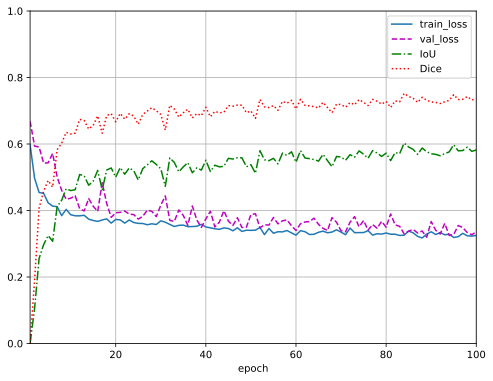

In [13]:
from d2l import torch as d2l

num_epochs = 100

# 一个 Animator，直接画 4 条曲线
animator = d2l.Animator(
    xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
    figsize=(8,6),
    legend=['train_loss', 'val_loss', 'IoU', 'Dice']
)


best_val_metrics = {"iou": 0, "dice": 0}



for epoch in range(num_epochs):
    
    # 1) 训练一个 epoch
    train_metrics = train_seg_one_epoch(model, train_loader, optimizer, criterion, device)
    # 2) 在 val 上验证
    val_metrics = eval_seg_one_epoch(model, val_loader, criterion, device, threshold=0.5)

    if val_metrics['iou'] > best_val_metrics["iou"]:
        best_val_metrics["iou"] = val_metrics["iou"]
        best_val_metrics["dice"] = val_metrics["dice"]
        torch.save(model.state_dict(), './outputs/msce_unet/best/unet_drive_best.pth')


    animator.add(
        epoch + 1,
        (
            train_metrics['train_loss'],
            val_metrics['val_loss'],
            val_metrics['iou'],
            val_metrics['dice'],
        )
    )

print(
    f"train_loss={train_metrics['train_loss']:.4f} |"
    f"val_loss={val_metrics['val_loss']:.4f} | "
    f"Best_IoU={best_val_metrics['iou']:.4f} | "
    f"Best_Dice={best_val_metrics['dice']:.4f} "
)
